### Intoduction to image segmentation in opencv in python  - 2022 0114 CJH
---
* if you don't have it, get it with `pip install opencv-python`

In [105]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### open image in correct color space and displaying with matplotlib

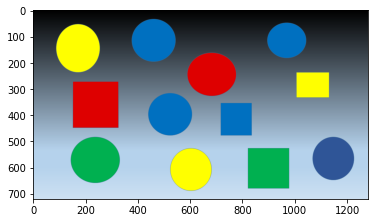

In [64]:
img_rgb = cv.cvtColor(cv.imread('colors.png'), cv.COLOR_BGR2RGB)
plt.imshow(img_rgb)   # Ploting the image using matplotlib

### blur - helps to remove noise

In [65]:
from enum import Enum
BlurType = Enum('BlurType', 'Box_Blur Gaussian_Blur Median_Filter Bilateral_Filter')
def blur(src, type, radius):
    """Softens an image using one of several filters.
    Args:
        src: The source mat (numpy.ndarray).
        type: The blurType to perform represented as an int.
        radius: The radius for the blur as a float.
    Returns:
        A numpy.ndarray that has been blurred.
    """
    if(type is BlurType.Box_Blur):
        ksize = int(2 * round(radius) + 1)
        return cv2.blur(src, (ksize, ksize))
    elif(type is BlurType.Gaussian_Blur):
        ksize = int(6 * round(radius) + 1)
        return cv2.GaussianBlur(src, (ksize, ksize), round(radius))
    elif(type is BlurType.Median_Filter):
        ksize = int(2 * round(radius) + 1)
        return cv2.medianBlur(src, ksize)
    else:
        return cv2.bilateralFilter(src, -1, round(radius), round(radius))

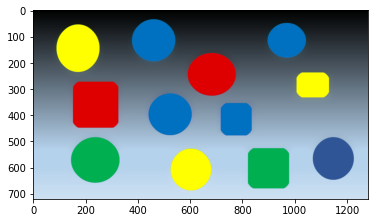

In [66]:
#blurred_image = img_rgb.copy()
blurred_image = blur(img_rgb.copy(), BlurType.Median_Filter, 20.0)
plt.imshow(blurred_image)

### hsv threshold - pick out colors

In [67]:
def hsv_threshold(input, hue, sat, val):
    """Segment an image based on hue, saturation, and value ranges.
    Args:
        input: A BGR numpy.ndarray.
        hue: A list of two numbers the are the min and max hue.
        sat: A list of two numbers the are the min and max saturation.
        lum: A list of two numbers the are the min and max value.
    Returns:
        A black and white numpy.ndarray.
    """
    out = cv2.cvtColor(input, cv2.COLOR_BGR2HSV)
    return cv2.inRange(out, (hue[0], sat[0], val[0]),  (hue[1], sat[1], val[1]))

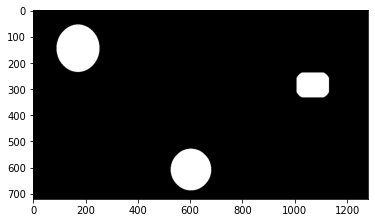

In [72]:
h = [85, 95]
s = [128, 255]
v = [100, 255]
hsv_thresh_image = hsv_threshold(blurred_image, h, s, v)
plt.imshow(hsv_thresh_image, cmap='gray')

### find contours

In [74]:
def find_contours(input, external_only):
    """Sets the values of pixels in a binary image to their distance to the nearest black pixel.
    Args:
        input: A numpy.ndarray.
        external_only: A boolean. If true only external contours are found.
    Return:
        A list of numpy.ndarray where each one represents a contour.
    """
    if(external_only):
        mode = cv2.RETR_EXTERNAL
    else:
        mode = cv2.RETR_LIST
    method = cv2.CHAIN_APPROX_SIMPLE
    contours, hierarchy =cv2.findContours(input, mode=mode, method=method)
    return contours

In [81]:
contours = find_contours(hsv_thresh_image, True)
len(contours)

3

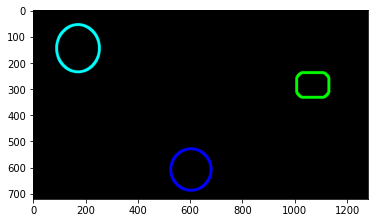

In [193]:
black = np.zeros_like(img_rgb)
for ix, contour in enumerate(contours):
    color = (([255*int(i) for i in f'{(ix+1) % 8:03b}']))
    cv2.drawContours(black , contours, ix, color, 10)
plt.imshow(black)

In [82]:
def filter_contours(input_contours, min_area, min_perimeter, min_width, max_width,
                    min_height, max_height, solidity, max_vertex_count, min_vertex_count,
                    min_ratio, max_ratio):
    """Filters out contours that do not meet certain criteria.
    Args:
        input_contours: Contours as a list of numpy.ndarray.
        min_area: The minimum area of a contour that will be kept.
        min_perimeter: The minimum perimeter of a contour that will be kept.
        min_width: Minimum width of a contour.
        max_width: MaxWidth maximum width.
        min_height: Minimum height.
        max_height: Maximimum height.
        solidity: The minimum and maximum solidity of a contour.
        min_vertex_count: Minimum vertex Count of the contours.
        max_vertex_count: Maximum vertex Count.
        min_ratio: Minimum ratio of width to height.
        max_ratio: Maximum ratio of width to height.
    Returns:
        Contours as a list of numpy.ndarray.
    """
    output = []
    for contour in input_contours:
        x,y,w,h = cv2.boundingRect(contour)
        if (w < min_width or w > max_width):
            continue
        if (h < min_height or h > max_height):
            continue
        area = cv2.contourArea(contour)
        if (area < min_area):
            continue
        if (cv2.arcLength(contour, True) < min_perimeter):
            continue
        hull = cv2.convexHull(contour)
        solid = 100 * area / cv2.contourArea(hull)
        if (solid < solidity[0] or solid > solidity[1]):
            continue
        if (len(contour) < min_vertex_count or len(contour) > max_vertex_count):
            continue
        ratio = (float)(w) / h
        if (ratio < min_ratio or ratio > max_ratio):
            continue
        output.append(contour)
    return output

In [87]:
min_area = 500.0
min_perimeter = 0.0
min_width = 10.0
max_width = 1000.0
min_height = 10.0
max_height = 1000
solidity = [24.280575539568343, 100.0]
max_vertices = 1000000
min_vertices = 0
min_ratio = 0.5
max_ratio = 1.5
filtered_contours = filter_contours(contours, min_area, min_perimeter, min_width, max_width,
                    min_height, max_height, solidity, max_vertices, min_vertices,
                    min_ratio, max_ratio)

In [89]:
len(filtered_contours)

3

In [198]:
def overlay_bounding_boxes(image, contours):
    """Draw a box around all of our contours with the main one emphasized"""
    for ix, contour in enumerate(contours):
        color = ([255*int(i) for i in f'{(ix+1) % 7:03b}'])
        rect = cv2.boundingRect(contour)
        thickness = 5
        #print(rect)
        image = cv2.rectangle(image, (int(rect[0]), int(rect[1])), (int(rect[0] + rect[2]), int(rect[1] + rect[3])), color, thickness)
    return image

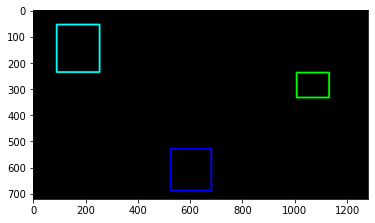

In [199]:
black = np.zeros_like(img_rgb)
contour_image = overlay_bounding_boxes(black, contours)
plt.imshow(contour_image)

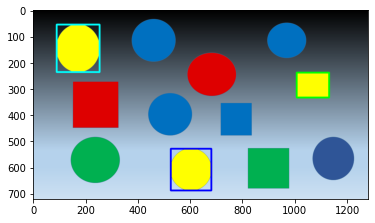

In [170]:
boxed_image = overlay_bounding_boxes(img_rgb.copy(), contours)
plt.imshow(boxed_image)

---
### putting it all together

In [200]:
def process(image):
    im = image.copy()
    blurred_image = blur(im, BlurType.Median_Filter, 20.0)
    hsv_thresh_image = hsv_threshold(blurred_image, h, s, v)
    contours = find_contours(hsv_thresh_image, True)
    filtered_contours = filter_contours(contours, min_area, min_perimeter, min_width, max_width,
                    min_height, max_height, solidity, max_vertices, min_vertices,
                    min_ratio, max_ratio)
    boxed_image = overlay_bounding_boxes(img_rgb.copy(), contours)
    plt.imshow(boxed_image)

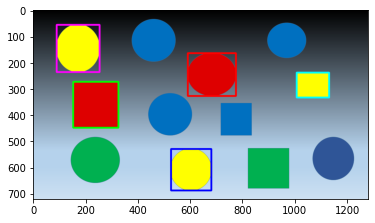

In [208]:
h = [90, 150]  # change the allowed hues
process(img_rgb)